<a href="https://colab.research.google.com/github/KhatijaBegum27/AI-ML-Projects/blob/main/FinancialDigitalTwin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install yfinance prophet tensorflow pandas numpy matplotlib scikit-learn stable-baselines3 gymnasium

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym
from gymnasium import spaces
from sklearn.metrics import mean_squared_error
from math import sqrt

In [9]:
# Data Layer

assets = {
    "S&P500": "^GSPC",
    "10Y_Treasury": "^TNX",
    "Gold": "GC=F",
    "Crude_Oil": "CL=F",
    "EURUSD": "EURUSD=X"
}

data = pd.DataFrame()
for name, sym in assets.items():
    df = yf.download(sym, start="2015-01-01", end="2025-01-01")
    data[name] = df["Adj Close"] if "Adj Close" in df.columns else df["Close"]

data = data.ffill().bfill()
returns = data.pct_change().dropna()
print("Data is ready:", data.shape)

/tmp/ipython-input-3466374815.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/tmp/ipython-input-3466374815.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timez

Fetching  data...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/tmp/ipython-input-3466374815.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, start="2015-01-01", end="2025-01-01")
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*********************100%***********************]  1 of 1 completed

Data is ready: (2516, 5)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
DEBUG:cmdstanpy:input tempfile: /tmp/tmplz9n9k15/bw4e6wvm.json
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
DEBUG:cmdstanpy:input tempfile: /tmp/tmplz9n9k15/n4btmk5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/d

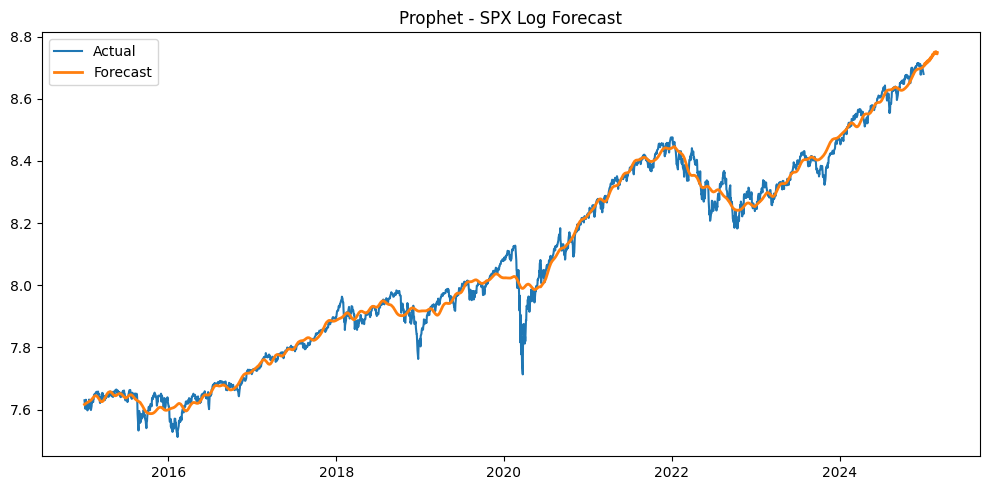

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
LSTM RMSE: 0.00803


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


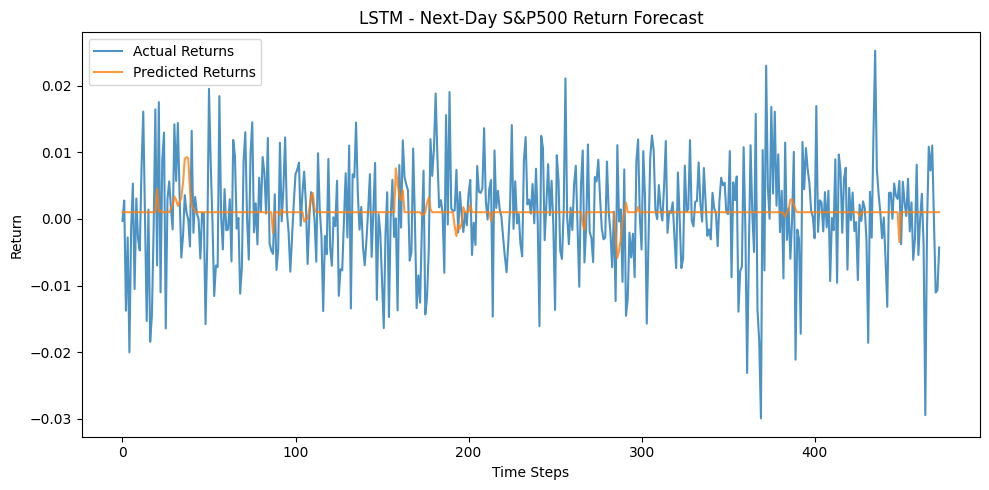

In [12]:
# Forecasting S&P500 with Prophet + LSTM

# Prophet (trend)
log_spx = np.log(data["S&P500"]).dropna()
df_p = log_spx.reset_index().rename(columns={"Date": "ds", "S&P500": "y"})
m = Prophet(yearly_seasonality=True)
m.fit(df_p)
future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)
# Plot Prophet Results
plt.figure(figsize=(10,5))
plt.plot(df_p["ds"], df_p["y"], label="Actual")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", linewidth=2)
plt.title("Prophet - SPX Log Forecast")
plt.legend(); plt.tight_layout(); plt.show()

# LSTM (short-term)
target = returns["S&P500"].shift(-1).dropna()
X = returns.loc[target.index]
split = int(len(X)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = target.iloc[:split], target.iloc[split:]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

def to_seq(X, y, lookback=30):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

Xtr, ytr = to_seq(X_train_s, y_train.values)
Xte, yte = to_seq(X_test_s, y_test.values)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(Xtr.shape[1], Xtr.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(Xtr, ytr, validation_split=0.2, epochs=50, batch_size=64, verbose=0)
y_pred = model.predict(Xte).ravel()
rmse = sqrt(mean_squared_error(yte, y_pred))
print(f"LSTM RMSE: {rmse:.5f}")
# --- Plot LSTM Results ---
plt.figure(figsize=(10,5))
plt.plot(yte, label="Actual Returns", alpha=0.8)
plt.plot(y_pred, label="Predicted Returns", alpha=0.8, linewidth=1.5)
plt.title("LSTM - Next-Day S&P500 Return Forecast")
plt.xlabel("Time Steps")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()

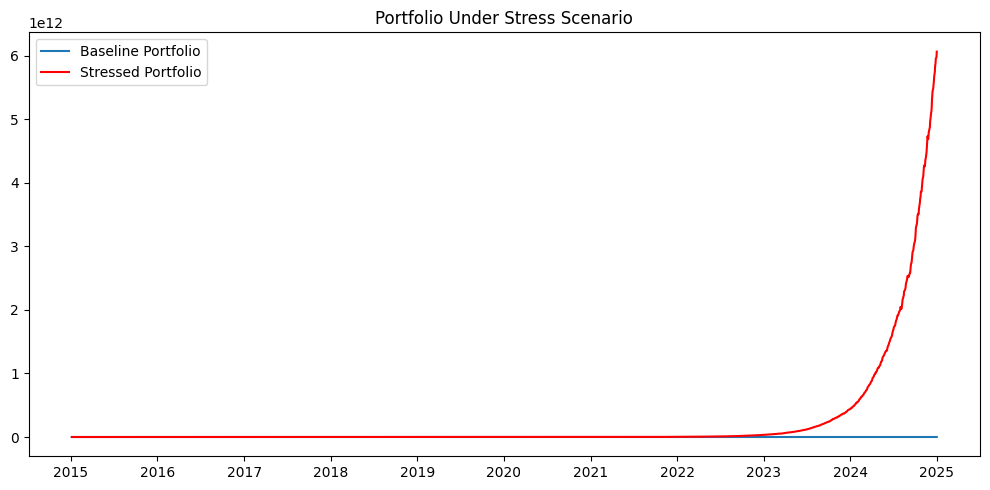

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [13]:
# Running stress test simulation
shock_factors = {"Rate_Shock": 0.02, "Gold_Surge": 0.03}
stress = returns.copy()
stress["10Y_Treasury"] += shock_factors["Rate_Shock"]
stress["Gold"] += shock_factors["Gold_Surge"]

eq_base = 100*np.cumprod(1+returns.mean(axis=1))
eq_stress = 100*np.cumprod(1+stress.mean(axis=1))

plt.figure(figsize=(10,5))
plt.plot(eq_base, label="Baseline Portfolio")
plt.plot(eq_stress, label="Stressed Portfolio", color="red")
plt.title("Portfolio Under Stress Scenario")
plt.legend(); plt.tight_layout(); plt.show()

In [22]:
# PROJECT SUMMARY
print("\n Project SUMMARY")
print("• Market Data Source: Yahoo Finance")
print("• Forecast Models: Prophet (trend) + LSTM (volatility)")
print("• Stress Testing: Rate + Gold shocks")
print("• Output: Forecast plots & Stress Simulation")


 Project SUMMARY
• Market Data Source: Yahoo Finance
• Forecast Models: Prophet (trend) + LSTM (volatility)
• Stress Testing: Rate + Gold shocks
• Output: Forecast plots & Stress Simulation
